In [1]:
import numpy as np
import os
from configparser import ConfigParser
from visualization import load_depth, draw3dbboxes_pillow, camera_to_string
import visualization
from PIL import Image
import pickle
import json
import time
from shutil import copyfile
import moviepy
from moviepy.editor import *
import matplotlib.pyplot as plt
import matplotlib as mpl
from joblib import Parallel, delayed

In [22]:
ini_file = "gta-postprocessing.ini"
visualization.multi_page = False
visualization.ini_file = ini_file
visualization.use_cache = False

conn = visualization.get_connection()
cur = conn.cursor()

CONFIG = ConfigParser()
CONFIG.read(ini_file)
in_directory = r'D:\output-datasets\offroad-11'
out_directory = r'D:\showing-videos\offroad-11'

directory_per_camera = True

In [23]:
#run_id = 19
#run_id = 3677
run_id = 4166

cur.execute("""SELECT imagepath, \
      ARRAY[st_x(camera_relative_rotation), st_y(camera_relative_rotation), st_z(camera_relative_rotation)] as camera_relative_rotation,
      ARRAY[st_x(camera_relative_position), st_y(camera_relative_position), st_z(camera_relative_position)] as camera_relative_position 
      FROM snapshots \
      WHERE run_id = {} AND camera_fov != 0 \
      ORDER BY timestamp ASC \
    """.format(run_id))
# camera fov is sanity check for malformed images
results = []
for row in cur:
    res = dict(row)
    #res['camera_relative_rotation'] = np.array(res['camera_relative_rotation'])
    results.append(res)

print('There are {} snapshots'.format(len(results)))

There are 3096 snapshots


In [24]:
# because sometimes I use two cameras heading same direction, pair (position, rotation) is unique identifier
cur.execute("""SELECT DISTINCT \
      ARRAY[st_x(camera_relative_rotation), st_y(camera_relative_rotation), st_z(camera_relative_rotation)] as camera_relative_rotation, 
      ARRAY[st_x(camera_relative_position), st_y(camera_relative_position), st_z(camera_relative_position)] as camera_relative_position 
      FROM snapshots \
      WHERE run_id = {} AND camera_fov != 0 \
      ORDER BY camera_relative_position, camera_relative_rotation ASC \
    """.format(run_id))
# camera fov is sanity check for malformed images
print('there are following relative camera rotations')
cam_configurations = []
camera_names = {}
for i, row in enumerate(cur):
    print(row['camera_relative_rotation'])
    print(row['camera_relative_position'])
    cam_configurations.append((row['camera_relative_rotation'], row['camera_relative_position']))
    camera_name = camera_to_string(row)
    camera_names[camera_name] = str(i)


there are following relative camera rotations
[-30.0, 0.0, 270.0]
[-16.0599994659424, 17.5, 6.07649993896484]
[0.0, 0.0, 0.0]
[-0.0599999986588955, 1.5, 1.07649993896484]
[270.0, 0.0, 90.0]
[-0.0599999986588955, 17.5, 25.0764999389648]
[-30.0, 0.0, 180.0]
[-0.0599999986588955, 33.5, 6.07649993896484]
[0.0, 0.0, 0.0]
[0.480000019073486, 1.5, 1.07649993896484]
[-30.0, 0.0, 90.0]
[15.9399995803833, 17.5, 6.07649993896484]


In [25]:
def split_results_by_relative_cam_configurations(results):
    res_groups = {}
    for cam_conf in cam_configurations:
        res_groups[str(cam_conf)] = [i for i in results if (i['camera_relative_rotation'], i['camera_relative_position']) == cam_conf]
    return res_groups

def result_group_to_video(results, suffix):
    if directory_per_camera:
        img_sequence = [os.path.join(in_directory, camera_names[camera_to_string(i)], i['imagepath']+suffix) for i in results]
    else:
        img_sequence = [os.path.join(in_directory, i['imagepath']+suffix) for i in results]
    
    img_sequence = [i for i in img_sequence if os.path.exists(i)]
    clip = ImageSequenceClip(img_sequence, fps=10)
    return clip

def process_depth_image(image):
    image = np.array(image.convert('RGB')) / np.iinfo(np.uint16).max
    return image
    
def result_depth_group_to_video(results, suffix):
    img_sequence = [os.path.join(in_directory, i['imagepath']+suffix) for i in results]
    img_sequence = [Image.open(i) for i in img_sequence]
    workers = 8
    img_sequence = Parallel(n_jobs=workers, backend='threading')(delayed(process_depth_image)(i) for i in img_sequence)
    clip = ImageSequenceClip(img_sequence, fps=10)
    # moviepy does not work with grayscale images yet
    #clip = clip.fl_image(process_depth_image)
    return clip

def process_stencil_image(colors, image):
    image = np.array(image) % 8
    image = colors[image]
    return image
    
def result_stencil_group_to_video(results, suffix):
    colors = (plt.cm.viridis(np.linspace(0, 1, 8))[:, :3] * np.iinfo(np.uint8).max).astype(np.uint8)
    img_sequence = [os.path.join(in_directory, i['imagepath']+suffix) for i in results]
    img_sequence = [Image.open(i) for i in img_sequence]  # IO operation, no need to perallelize
    # from 60 to 16 seconds sppedup, nice, all cores at full load
    workers = 8
    img_sequence = Parallel(n_jobs=workers, backend='threading')(delayed(process_stencil_image)(colors, i) for i in img_sequence)
    clip = ImageSequenceClip(img_sequence, fps=10)
    # moviepy does not work with grayscale images yet
    #clip = clip.fl_image(process_stencil_image)
    return clip


### preparing data

In [26]:
result_groups = split_results_by_relative_cam_configurations(results)


In [27]:
for cam_conf, res in result_groups.items():
    print(cam_conf)
    print(len(res))

([-30.0, 0.0, 270.0], [-16.0599994659424, 17.5, 6.07649993896484])
519
([0.0, 0.0, 0.0], [-0.0599999986588955, 1.5, 1.07649993896484])
518
([270.0, 0.0, 90.0], [-0.0599999986588955, 17.5, 25.0764999389648])
509
([-30.0, 0.0, 180.0], [-0.0599999986588955, 33.5, 6.07649993896484])
519
([0.0, 0.0, 0.0], [0.480000019073486, 1.5, 1.07649993896484])
515
([-30.0, 0.0, 90.0], [15.9399995803833, 17.5, 6.07649993896484])
516


### dumping data to videos

In [28]:
# splitting individual videos into functions, so they are not buffered at once into the memory
def make_rgb_video(cam_conf, res):
    clip = result_group_to_video(res, '.jpg')
    video_name = os.path.join(out_directory, "camera-{}.mp4".format(cam_conf))
    clip.write_videofile(video_name, audio=False, codec='mpeg4', threads=8)

def make_depth_video(cam_conf, res):
    depth_clip = result_depth_group_to_video(res, '-depth.png')
    video_name = os.path.join(out_directory, "camera-{}-depth.mp4".format(cam_conf))
    depth_clip.write_videofile(video_name, audio=False, codec='mpeg4')

def make_stencil_video(cam_conf, res):
    stencil_clip = result_stencil_group_to_video(res, '-stencil.png')
    video_name = os.path.join(out_directory, "camera-{}-stencil.mp4".format(cam_conf))
    stencil_clip.write_videofile(video_name, audio=False, codec='mpeg4')
    
for cam_conf, res in result_groups.items():
    make_rgb_video(cam_conf, res)
    # beware, following two lines eat shitload of RAM
    #make_depth_video(cam_conf, res)
    #make_stencil_video(cam_conf, res)
    
#time to load images 23.967074155807495
#time to transform images 51.597939252853394
#time to prepare sequence clip 0.0010004043579101562

#time to load images 0.28050708770751953
#time to transform images 63.57286500930786
#time to prepare sequence clip 0.0005006790161132812

[MoviePy] >>>> Building video D:\showing-videos\offroad-11\camera-([-30.0, 0.0, 270.0], [-16.0599994659424, 17.5, 6.07649993896484]).mp4
[MoviePy] Writing video D:\showing-videos\offroad-11\camera-([-30.0, 0.0, 270.0], [-16.0599994659424, 17.5, 6.07649993896484]).mp4


  0%|                                                                                          | 0/519 [00:00<?, ?it/s]


OSError: [Errno 22] Invalid argument

MoviePy error: FFMPEG encountered the following error while writing file D:\showing-videos\offroad-11\camera-([-30.0, 0.0, 270.0], [-16.0599994659424, 17.5, 6.07649993896484]).mp4:

 b'D:\\showing-videos\\offroad-11\\camera-([-30.0, 0.0, 270.0], [-16.0599994659424, 17.5, 6.07649993896484]).mp4: No such file or directory\r\n'

In [13]:
# copied from ImageSequenceClip constructor
def find_image_index(clip, t):
    return max([i for i in range(len(clip.sequence))
                      if clip.images_starts[i]<=t])

def get_base_name(name):
    return os.path.basename(os.path.splitext(name)[0])

def draw_bboxes(rgb, path, directory):
    base_name = get_base_name(path)
    depth_file = os.path.join(directory, '{}-depth.png'.format(base_name))
    json_file = os.path.join(directory, '{}.json'.format(base_name))
    depth = np.array(Image.open(depth_file))
    depth = depth / np.iinfo(np.uint16).max  # normalizing into NDC
    with open(json_file, mode='r') as f:
        data = json.load(f)
    im = draw3dbboxes_pillow(rgb, depth, data)
    return np.array(im)
    
def result_group_to_video_with_bboxes(results, suffix):
    img_sequence = [os.path.join(in_directory, i['imagepath']+suffix) for i in results]
    img_sequence = [i for i in img_sequence if os.path.exists(i)]
    clip = ImageSequenceClip(img_sequence, fps=10)
    #clip = clip.fl_image(draw_bboxes)
    clip = clip.fl(lambda gf, t: draw_bboxes(gf(t), clip.sequence[find_image_index(clip, t)], in_directory), []) # instead of fl_image, here I use fl, so I access both image and its name

    return clip

def make_rgb_video_with_bboxes(cam_conf, res):
    clip = result_group_to_video_with_bboxes(res, '.jpg')
    video_name = os.path.join(out_directory, "camera-{}-annotated.mp4".format(cam_conf))
    clip.write_videofile(video_name, audio=False, codec='mpeg4', threads=8)


In [14]:
for cam_conf, res in result_groups.items():
    make_rgb_video_with_bboxes(cam_conf, res)
    break


[MoviePy] >>>> Building video D:\showing-videos\onroad-1\camera-([0.0, 0.0, 0.0], [0.0, 2.0, 0.300000011920929])-annotated.mp4
[MoviePy] Writing video D:\showing-videos\onroad-1\camera-([0.0, 0.0, 0.0], [0.0, 2.0, 0.300000011920929])-annotated.mp4





  0%|                                                                                         | 0/1292 [00:00<?, ?it/s]


  0%|▏                                                                                | 2/1292 [00:00<02:59,  7.17it/s]


  0%|▏                                                                                | 3/1292 [00:00<03:25,  6.28it/s]


  0%|▎                                                                                | 4/1292 [00:01<06:01,  3.56it/s]


  0%|▎                                                                                | 5/1292 [00:02<10:48,  1.98it/s]


  0%|▍                                                                                | 6/1292 [00:02<08:45,  2.45it/s]


  1%|▍                                                                                | 7/1292 [00:02<09:52,  2.17it/s]


  1%|▌                                                                                | 8/1292 [00:03<10:42,  2.00it/s]


  1%|▌               

  5%|████▎                                                                           | 69/1292 [00:24<05:08,  3.97it/s]


  5%|████▎                                                                           | 70/1292 [00:24<04:34,  4.45it/s]


  5%|████▍                                                                           | 71/1292 [00:24<04:04,  5.00it/s]


  6%|████▍                                                                           | 72/1292 [00:24<03:45,  5.42it/s]


  6%|████▌                                                                           | 73/1292 [00:24<03:31,  5.75it/s]


  6%|████▌                                                                           | 74/1292 [00:25<05:36,  3.62it/s]


  6%|████▋                                                                           | 75/1292 [00:25<07:00,  2.89it/s]


  6%|████▋                                                                           | 76/1292 [00:27<12:36,  1.61it/s]


  6%|████▊              

 11%|████████▎                                                                      | 136/1292 [01:03<08:39,  2.23it/s]


 11%|████████▍                                                                      | 137/1292 [01:03<06:54,  2.79it/s]


 11%|████████▍                                                                      | 138/1292 [01:03<05:41,  3.38it/s]


 11%|████████▍                                                                      | 139/1292 [01:03<04:53,  3.93it/s]


 11%|████████▌                                                                      | 140/1292 [01:03<04:13,  4.54it/s]


 11%|████████▌                                                                      | 141/1292 [01:04<03:52,  4.94it/s]


 11%|████████▋                                                                      | 142/1292 [01:04<05:40,  3.37it/s]


 11%|████████▋                                                                      | 143/1292 [01:05<07:15,  2.64it/s]


 11%|████████▊          

 16%|████████████▍                                                                  | 203/1292 [01:23<06:26,  2.82it/s]


 16%|████████████▍                                                                  | 204/1292 [01:24<05:31,  3.28it/s]


 16%|████████████▌                                                                  | 205/1292 [01:24<07:09,  2.53it/s]


 16%|████████████▌                                                                  | 206/1292 [01:24<06:05,  2.97it/s]


 16%|████████████▋                                                                  | 207/1292 [01:25<07:13,  2.50it/s]


 16%|████████████▋                                                                  | 208/1292 [01:26<08:11,  2.21it/s]


 16%|████████████▊                                                                  | 209/1292 [01:27<11:18,  1.60it/s]


 16%|████████████▊                                                                  | 210/1292 [01:27<11:59,  1.50it/s]


 16%|████████████▉      

 21%|████████████████▌                                                              | 270/1292 [02:07<09:54,  1.72it/s]


 21%|████████████████▌                                                              | 271/1292 [02:07<07:50,  2.17it/s]


 21%|████████████████▋                                                              | 272/1292 [02:08<10:19,  1.65it/s]


 21%|████████████████▋                                                              | 273/1292 [02:10<13:56,  1.22it/s]


 21%|████████████████▊                                                              | 274/1292 [02:10<12:22,  1.37it/s]


 21%|████████████████▊                                                              | 275/1292 [02:10<09:32,  1.77it/s]


 21%|████████████████▉                                                              | 276/1292 [02:11<09:12,  1.84it/s]


 21%|████████████████▉                                                              | 277/1292 [02:12<10:51,  1.56it/s]


 22%|████████████████▉  

 26%|████████████████████▌                                                          | 337/1292 [02:59<14:42,  1.08it/s]


 26%|████████████████████▋                                                          | 338/1292 [03:00<13:38,  1.17it/s]


 26%|████████████████████▋                                                          | 339/1292 [03:00<13:15,  1.20it/s]


 26%|████████████████████▊                                                          | 340/1292 [03:02<15:35,  1.02it/s]


 26%|████████████████████▊                                                          | 341/1292 [03:02<14:20,  1.10it/s]


 26%|████████████████████▉                                                          | 342/1292 [03:03<12:59,  1.22it/s]


 27%|████████████████████▉                                                          | 343/1292 [03:04<13:33,  1.17it/s]


 27%|█████████████████████                                                          | 344/1292 [03:04<10:18,  1.53it/s]


 27%|███████████████████

 31%|████████████████████████▋                                                      | 404/1292 [03:48<12:31,  1.18it/s]


 31%|████████████████████████▊                                                      | 405/1292 [03:49<09:30,  1.55it/s]


 31%|████████████████████████▊                                                      | 406/1292 [03:49<07:25,  1.99it/s]


 32%|████████████████████████▉                                                      | 407/1292 [03:49<05:59,  2.46it/s]


 32%|████████████████████████▉                                                      | 408/1292 [03:49<04:50,  3.04it/s]


 32%|█████████████████████████                                                      | 409/1292 [03:49<04:05,  3.60it/s]


 32%|█████████████████████████                                                      | 410/1292 [03:50<05:08,  2.86it/s]


 32%|█████████████████████████▏                                                     | 411/1292 [03:51<08:11,  1.79it/s]


 32%|███████████████████

 36%|████████████████████████████▊                                                  | 471/1292 [04:30<08:41,  1.58it/s]


 37%|████████████████████████████▊                                                  | 472/1292 [04:30<09:20,  1.46it/s]


 37%|████████████████████████████▉                                                  | 473/1292 [04:32<11:30,  1.19it/s]


 37%|████████████████████████████▉                                                  | 474/1292 [04:32<11:38,  1.17it/s]


 37%|█████████████████████████████                                                  | 475/1292 [04:33<10:27,  1.30it/s]


 37%|█████████████████████████████                                                  | 476/1292 [04:33<08:01,  1.69it/s]


 37%|█████████████████████████████▏                                                 | 477/1292 [04:34<07:38,  1.78it/s]


 37%|█████████████████████████████▏                                                 | 478/1292 [04:34<06:01,  2.25it/s]


 37%|███████████████████

 42%|████████████████████████████████▉                                              | 538/1292 [05:02<04:43,  2.66it/s]


 42%|████████████████████████████████▉                                              | 539/1292 [05:03<05:09,  2.44it/s]


 42%|█████████████████████████████████                                              | 540/1292 [05:03<04:14,  2.95it/s]


 42%|█████████████████████████████████                                              | 541/1292 [05:03<03:38,  3.44it/s]


 42%|█████████████████████████████████▏                                             | 542/1292 [05:03<03:10,  3.93it/s]


 42%|█████████████████████████████████▏                                             | 543/1292 [05:04<03:58,  3.14it/s]


 42%|█████████████████████████████████▎                                             | 544/1292 [05:04<03:25,  3.65it/s]


 42%|█████████████████████████████████▎                                             | 545/1292 [05:04<02:58,  4.19it/s]


 42%|███████████████████

 47%|████████████████████████████████████▉                                          | 605/1292 [05:29<06:38,  1.72it/s]


 47%|█████████████████████████████████████                                          | 606/1292 [05:30<07:29,  1.52it/s]


 47%|█████████████████████████████████████                                          | 607/1292 [05:30<07:06,  1.61it/s]


 47%|█████████████████████████████████████▏                                         | 608/1292 [05:31<05:32,  2.06it/s]


 47%|█████████████████████████████████████▏                                         | 609/1292 [05:31<04:23,  2.59it/s]


 47%|█████████████████████████████████████▎                                         | 610/1292 [05:31<04:43,  2.41it/s]


 47%|█████████████████████████████████████▎                                         | 611/1292 [05:32<05:01,  2.26it/s]


 47%|█████████████████████████████████████▍                                         | 612/1292 [05:32<04:02,  2.80it/s]


 47%|███████████████████

 52%|█████████████████████████████████████████                                      | 672/1292 [05:59<02:52,  3.59it/s]


 52%|█████████████████████████████████████████▏                                     | 673/1292 [06:00<03:25,  3.01it/s]


 52%|█████████████████████████████████████████▏                                     | 674/1292 [06:00<02:58,  3.46it/s]


 52%|█████████████████████████████████████████▎                                     | 675/1292 [06:00<02:31,  4.08it/s]


 52%|█████████████████████████████████████████▎                                     | 676/1292 [06:00<02:15,  4.56it/s]


 52%|█████████████████████████████████████████▍                                     | 677/1292 [06:00<02:02,  5.00it/s]


 52%|█████████████████████████████████████████▍                                     | 678/1292 [06:01<02:57,  3.46it/s]


 53%|█████████████████████████████████████████▌                                     | 679/1292 [06:01<02:35,  3.94it/s]


 53%|███████████████████

 57%|█████████████████████████████████████████████▏                                 | 739/1292 [06:28<03:06,  2.97it/s]


 57%|█████████████████████████████████████████████▏                                 | 740/1292 [06:28<02:39,  3.46it/s]


 57%|█████████████████████████████████████████████▎                                 | 741/1292 [06:29<03:09,  2.91it/s]


 57%|█████████████████████████████████████████████▎                                 | 742/1292 [06:29<03:37,  2.53it/s]


 58%|█████████████████████████████████████████████▍                                 | 743/1292 [06:29<03:00,  3.04it/s]


 58%|█████████████████████████████████████████████▍                                 | 744/1292 [06:30<03:28,  2.63it/s]


 58%|█████████████████████████████████████████████▌                                 | 745/1292 [06:31<06:42,  1.36it/s]


 58%|█████████████████████████████████████████████▌                                 | 746/1292 [06:31<05:06,  1.78it/s]


 58%|███████████████████

 62%|█████████████████████████████████████████████████▎                             | 806/1292 [06:54<03:54,  2.07it/s]


 62%|█████████████████████████████████████████████████▎                             | 807/1292 [06:56<05:27,  1.48it/s]


 63%|█████████████████████████████████████████████████▍                             | 808/1292 [06:56<05:50,  1.38it/s]


 63%|█████████████████████████████████████████████████▍                             | 809/1292 [06:57<05:14,  1.54it/s]


 63%|█████████████████████████████████████████████████▌                             | 810/1292 [06:57<04:47,  1.68it/s]


 63%|█████████████████████████████████████████████████▌                             | 811/1292 [06:58<05:44,  1.40it/s]


 63%|█████████████████████████████████████████████████▋                             | 812/1292 [06:59<06:14,  1.28it/s]


 63%|█████████████████████████████████████████████████▋                             | 813/1292 [07:00<06:34,  1.22it/s]


 63%|███████████████████

 68%|█████████████████████████████████████████████████████▍                         | 873/1292 [07:26<01:44,  4.01it/s]


 68%|█████████████████████████████████████████████████████▍                         | 874/1292 [07:27<02:56,  2.37it/s]


 68%|█████████████████████████████████████████████████████▌                         | 875/1292 [07:27<02:22,  2.93it/s]


 68%|█████████████████████████████████████████████████████▌                         | 876/1292 [07:28<01:56,  3.57it/s]


 68%|█████████████████████████████████████████████████████▌                         | 877/1292 [07:28<01:39,  4.18it/s]


 68%|█████████████████████████████████████████████████████▋                         | 878/1292 [07:28<01:26,  4.77it/s]


 68%|█████████████████████████████████████████████████████▋                         | 879/1292 [07:28<02:02,  3.38it/s]


 68%|█████████████████████████████████████████████████████▊                         | 880/1292 [07:29<02:25,  2.83it/s]


 68%|███████████████████

 73%|█████████████████████████████████████████████████████████▍                     | 940/1292 [07:50<02:19,  2.53it/s]


 73%|█████████████████████████████████████████████████████████▌                     | 941/1292 [07:51<01:53,  3.08it/s]


 73%|█████████████████████████████████████████████████████████▌                     | 942/1292 [07:51<01:37,  3.59it/s]


 73%|█████████████████████████████████████████████████████████▋                     | 943/1292 [07:51<02:00,  2.89it/s]


 73%|█████████████████████████████████████████████████████████▋                     | 944/1292 [07:51<01:41,  3.44it/s]


 73%|█████████████████████████████████████████████████████████▊                     | 945/1292 [07:52<01:26,  4.01it/s]


 73%|█████████████████████████████████████████████████████████▊                     | 946/1292 [07:52<01:53,  3.06it/s]


 73%|█████████████████████████████████████████████████████████▉                     | 947/1292 [07:53<02:11,  2.63it/s]


 73%|███████████████████

 78%|████████████████████████████████████████████████████████████▊                 | 1007/1292 [08:19<01:54,  2.50it/s]


 78%|████████████████████████████████████████████████████████████▊                 | 1008/1292 [08:19<02:04,  2.28it/s]


 78%|████████████████████████████████████████████████████████████▉                 | 1009/1292 [08:20<01:41,  2.79it/s]


 78%|████████████████████████████████████████████████████████████▉                 | 1010/1292 [08:20<01:55,  2.44it/s]


 78%|█████████████████████████████████████████████████████████████                 | 1011/1292 [08:21<02:03,  2.27it/s]


 78%|█████████████████████████████████████████████████████████████                 | 1012/1292 [08:21<01:41,  2.77it/s]


 78%|█████████████████████████████████████████████████████████████▏                | 1013/1292 [08:21<01:23,  3.33it/s]


 78%|█████████████████████████████████████████████████████████████▏                | 1014/1292 [08:21<01:41,  2.74it/s]


 79%|███████████████████

 83%|████████████████████████████████████████████████████████████████▊             | 1074/1292 [09:02<02:03,  1.76it/s]


 83%|████████████████████████████████████████████████████████████████▉             | 1075/1292 [09:02<02:01,  1.79it/s]


 83%|████████████████████████████████████████████████████████████████▉             | 1076/1292 [09:02<01:36,  2.24it/s]


 83%|█████████████████████████████████████████████████████████████████             | 1077/1292 [09:03<01:19,  2.72it/s]


 83%|█████████████████████████████████████████████████████████████████             | 1078/1292 [09:03<01:29,  2.38it/s]


 84%|█████████████████████████████████████████████████████████████████▏            | 1079/1292 [09:04<01:36,  2.21it/s]


 84%|█████████████████████████████████████████████████████████████████▏            | 1080/1292 [09:05<02:04,  1.71it/s]


 84%|█████████████████████████████████████████████████████████████████▎            | 1081/1292 [09:06<02:41,  1.31it/s]


 84%|███████████████████

 88%|████████████████████████████████████████████████████████████████████▉         | 1141/1292 [10:06<01:49,  1.38it/s]


 88%|████████████████████████████████████████████████████████████████████▉         | 1142/1292 [10:06<01:38,  1.52it/s]


 88%|█████████████████████████████████████████████████████████████████████         | 1143/1292 [10:07<01:32,  1.61it/s]


 89%|█████████████████████████████████████████████████████████████████████         | 1144/1292 [10:07<01:29,  1.66it/s]


 89%|█████████████████████████████████████████████████████████████████████▏        | 1145/1292 [10:08<01:25,  1.71it/s]


 89%|█████████████████████████████████████████████████████████████████████▏        | 1146/1292 [10:08<01:23,  1.75it/s]


 89%|█████████████████████████████████████████████████████████████████████▏        | 1147/1292 [10:09<01:20,  1.81it/s]


 89%|█████████████████████████████████████████████████████████████████████▎        | 1148/1292 [10:09<01:03,  2.27it/s]


 89%|███████████████████

 93%|████████████████████████████████████████████████████████████████████████▉     | 1208/1292 [11:17<00:56,  1.50it/s]


 94%|████████████████████████████████████████████████████████████████████████▉     | 1209/1292 [11:18<00:51,  1.60it/s]


 94%|█████████████████████████████████████████████████████████████████████████     | 1210/1292 [11:18<00:39,  2.05it/s]


 94%|█████████████████████████████████████████████████████████████████████████     | 1211/1292 [11:18<00:40,  1.99it/s]


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1212/1292 [11:19<00:55,  1.43it/s]


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1213/1292 [11:21<01:05,  1.20it/s]


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1214/1292 [11:22<01:18,  1.00s/it]


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1215/1292 [11:23<01:06,  1.16it/s]


 94%|███████████████████

 99%|████████████████████████████████████████████████████████████████████████████▉ | 1275/1292 [12:25<00:25,  1.51s/it]


 99%|█████████████████████████████████████████████████████████████████████████████ | 1276/1292 [12:26<00:22,  1.40s/it]


 99%|█████████████████████████████████████████████████████████████████████████████ | 1277/1292 [12:27<00:19,  1.32s/it]


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1278/1292 [12:28<00:16,  1.17s/it]


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1279/1292 [12:29<00:14,  1.14s/it]


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1280/1292 [12:30<00:13,  1.13s/it]


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1281/1292 [12:32<00:13,  1.19s/it]


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1282/1292 [12:32<00:10,  1.08s/it]


 99%|███████████████████

[MoviePy] Done.
[MoviePy] >>>> Video ready: D:\showing-videos\onroad-1\camera-([0.0, 0.0, 0.0], [0.0, 2.0, 0.300000011920929])-annotated.mp4 



In [ ]:
name = os.path.join(in_directory, result_groups['[0, 0, 0]'][0]['imagepath']+'-depth.png')
depth_arr = np.array(Image.open(name).convert('RGB'))
depth_arr_2 = np.array(Image.open(name).convert('L').convert('RGB'))
depth_arr_3 = np.array(Image.open(name).convert('L'))
arr_single = np.array(Image.open(name))

In [ ]:
depth_arr.max()

In [ ]:
arr_single.max()

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10, 10))
plt.imshow(arr_single, cmap='gray')
plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(depth_arr_3, cmap='gray')
plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(depth_arr_2)
plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(depth_arr)
plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.hist(arr_single.flatten())
plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.hist(depth_arr.flatten())
plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.hist(depth_arr_2.flatten())
plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 10))
plt.hist(depth_arr_3.flatten())
plt.show()

In [37]:
arr_single_cropped = arr_single[arr_single < 256]
fig = plt.figure(figsize=(10, 10))
plt.hist(arr_single_cropped.flatten())
plt.show()

NameError: name 'arr_single' is not defined

In [116]:
im_stencil = os.path.join(in_directory, next(iter(result_groups.values()))[0]['imagepath']+'-stencil.png')
im_stencil = np.array(Image.open(im_stencil))
im_stencil = im_stencil % 8
colors = (plt.cm.viridis(np.linspace(0, 1, 8))[:, :3] * np.iinfo(np.uint8).max).astype(np.uint8)
im_stencil = colors[im_stencil]

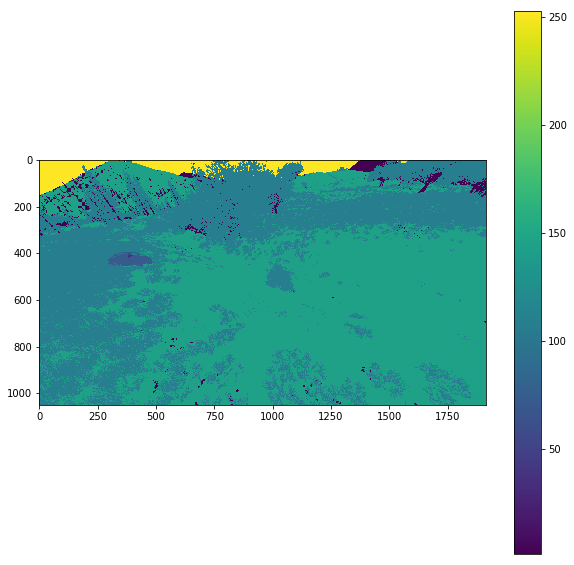

In [117]:
fig = plt.figure(figsize=(10, 10))
ii = plt.imshow(im_stencil)
plt.colorbar(ii)
plt.show()

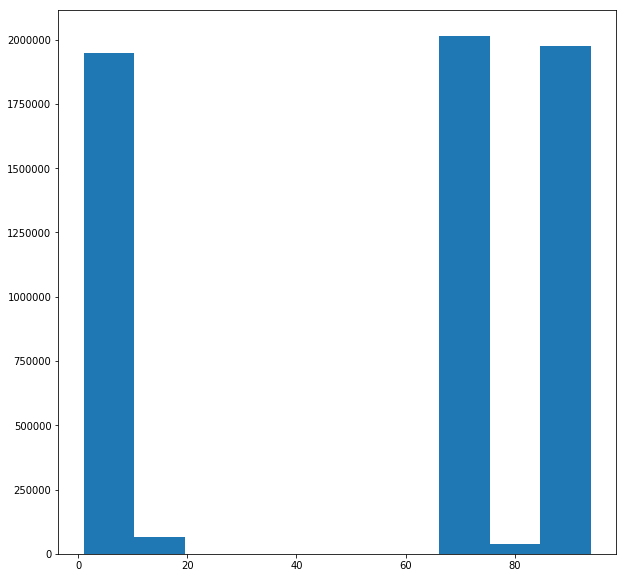

In [56]:
fig = plt.figure(figsize=(10, 10))
plt.hist(im_stencil.flatten())
plt.show()